# Starter Notebook: Economic Well-Being Prediction Challenge

Welcome! This starter notebook is designed to get you started on this challenge, where you will be attempting to predict a measure of wealth for different locations across Africa. We will take a look at the data, create a model and then use that to make our first submission. After that we will briefly look at some ways to improve. Let's get started.

# Loading the Data

We're using the pandas library to load the data into dataframes - a tabular data structure that is perfect for this kind of work. Each of the three CSV files from Zindi is loaded into a dataframe and we take a look at the shape of the data (number of rows and columns) as well as a preview of the first 5 rows to get a feel for what we're working with.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,SpatialDropout1D,Flatten
from keras.initializers import Constant
from keras.regularizers import l2
from keras.optimizers import Adam
%matplotlib inline
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':100})

Using TensorFlow backend.


In [2]:
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(21454, 19)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In train, we have a set of inputs (like 'urban_or_rural' or 'ghsl_water_surface') and our desired output variable, 'Target'. There are 21454 rows - lots of juicy data!

In [3]:
test = pd.read_csv('Test.csv')
print(test.shape)
test.head()

(7194, 18)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,Uganda,2011,U,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334
3,ID_AAmMOEEC,Burkina Faso,2010,U,0.000000,0.000089,0.000036,0.001519,0.001358,0.996997,35.141762,33.878927,4.166437,0.000000,0.130727,1.333999,109.493969,775.139189
4,ID_ABguzDxp,Zambia,2007,R,0.000000,0.000138,0.000623,0.000615,0.002961,0.995663,3.442449,33.491994,3.437129,0.133563,0.128997,0.502203,133.643319,835.591501


Test looks just like train but without the 'Target' column and with fewer rows.

In [4]:
ss = pd.read_csv('SampleSubmission.csv')
print(ss.shape)
ss.head()

(7194, 2)


,ID,Target
0,ID_AAcismbB,0
1,ID_AAeBMsji,0
2,ID_AAjFMjzy,0
3,ID_AAmMOEEC,0
4,ID_ABguzDxp,0


The sample submission is just the ID column from test with a 'Target' column where we will put out predictions.

Now that we have the data loaded, we can start exploring.

# EDA

We will explore some trends in the data and look for any anomalies such as missing data. A few examples are done here but you can explore much further yourself and get to know the data better.

First up: let's see how an input like 'nighttime lights' relates to the target column:

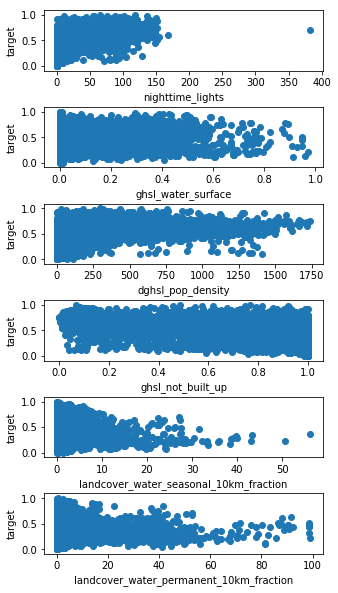

In [5]:
fig = plt.figure()
fig, ax = plt.subplots(6, figsize=(5, 10))

ax[0].scatter(x = train['nighttime_lights'], y = train['Target'])
ax[0].set_xlabel('nighttime_lights')
ax[0].set_ylabel('target')

ax[1].scatter(x = train['ghsl_water_surface'], y = train['Target'])
ax[1].set_xlabel('ghsl_water_surface')
ax[1].set_ylabel("target")

ax[2].scatter(x = train['ghsl_pop_density'], y = train['Target'])
ax[2].set_xlabel('dghsl_pop_density')
ax[2].set_ylabel("target")

ax[3].scatter(x = train['ghsl_not_built_up'], y = train['Target'])
ax[3].set_xlabel('ghsl_not_built_up')
ax[3].set_ylabel("target")

ax[4].scatter(x = train['landcover_water_seasonal_10km_fraction'], y = train['Target'])
ax[4].set_xlabel('landcover_water_seasonal_10km_fraction')
ax[4].set_ylabel("target")

ax[5].scatter(x = train['landcover_water_permanent_10km_fraction'], y = train['Target'])
ax[5].set_xlabel('landcover_water_permanent_10km_fraction')
ax[5].set_ylabel("target")


plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.show()

In [6]:
pd.set_option('precision', 2)
print(train.describe())

           year  ghsl_water_surface  ghsl_built_pre_1975  \
count  21454.00            21454.00             2.15e+04   
mean    2010.06                0.03             3.82e-02   
std        4.80                0.10             1.14e-01   
min     1994.00                0.00             0.00e+00   
25%     2008.00                0.00             0.00e+00   
50%     2011.00                0.00             1.98e-04   
75%     2014.00                0.00             7.99e-03   
max     2016.00                0.97             8.77e-01   

       ghsl_built_1975_to_1990  ghsl_built_1990_to_2000  \
count                 2.15e+04                 2.15e+04   
mean                  2.86e-02                 1.27e-02   
std                   7.74e-02                 3.27e-02   
min                   0.00e+00                 0.00e+00   
25%                   0.00e+00                 4.28e-05   
50%                   7.09e-04                 1.00e-03   
75%                   9.87e-03                

**Correlation between variables**

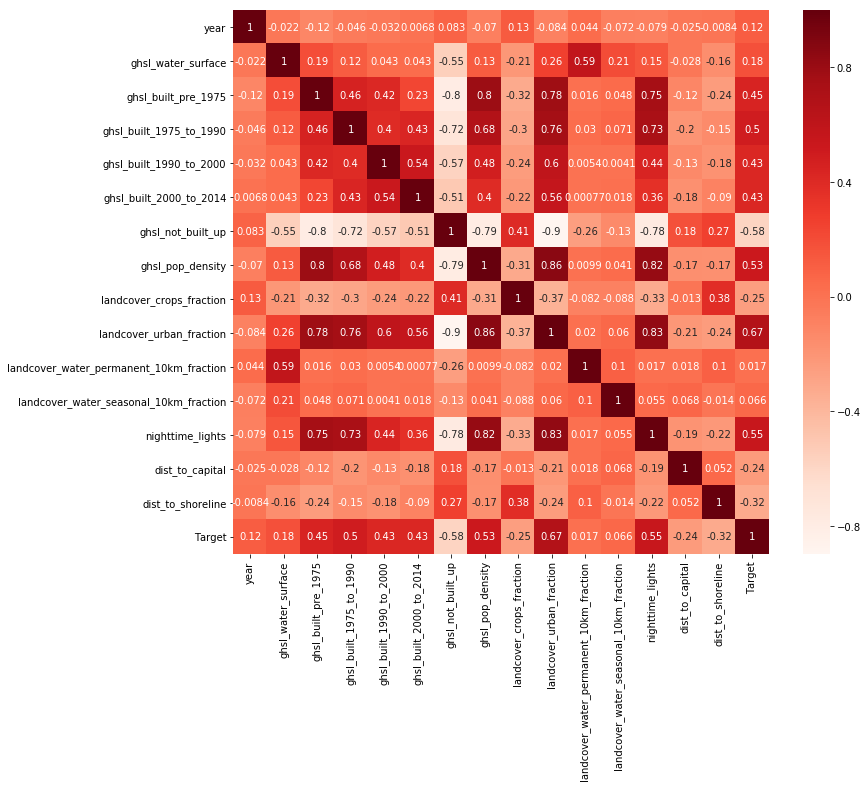

In [7]:
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
#Correlation with output variable
cor_target = abs(cor["Target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

ghsl_built_1975_to_1990     0.50
ghsl_not_built_up           0.58
ghsl_pop_density            0.53
landcover_urban_fraction    0.67
nighttime_lights            0.55
Target                      1.00
Name: Target, dtype: float64

In [9]:
print(train[["ghsl_built_1975_to_1990","ghsl_not_built_up"]].corr())
print(train[["ghsl_pop_density","landcover_urban_fraction"]].corr())
print(train[["ghsl_built_1975_to_1990","nighttime_lights"]].corr())

                         ghsl_built_1975_to_1990  ghsl_not_built_up
ghsl_built_1975_to_1990                     1.00              -0.72
ghsl_not_built_up                          -0.72               1.00
                          ghsl_pop_density  landcover_urban_fraction
ghsl_pop_density                      1.00                      0.86
landcover_urban_fraction              0.86                      1.00
                         ghsl_built_1975_to_1990  nighttime_lights
ghsl_built_1975_to_1990                     1.00              0.73
nighttime_lights                            0.73              1.00


**Check for outliers**

In [10]:
def outliers_prop(feature):
    Q1 = train[feature].quantile(0.25)
    Q3 = train[feature].quantile(0.75)
    IQR = Q3 - Q1

    outliers_len = ((train[feature] < (Q1 - 1.5 * IQR)) | (train[feature] > (Q3 + 1.5 * IQR))).sum()

    return outliers_len/len(train[feature])

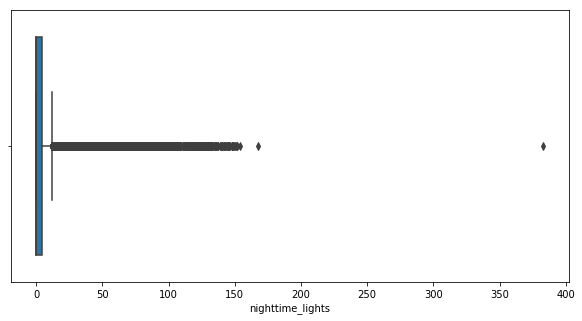

In [11]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['nighttime_lights'])

In [12]:
print(outliers_prop('nighttime_lights'))

0.15964388925142164


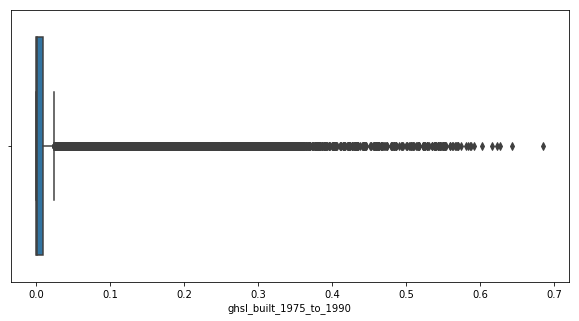

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['ghsl_built_1975_to_1990'])

In [14]:
print(outliers_prop('ghsl_built_1975_to_1990'))

0.18155122587862405


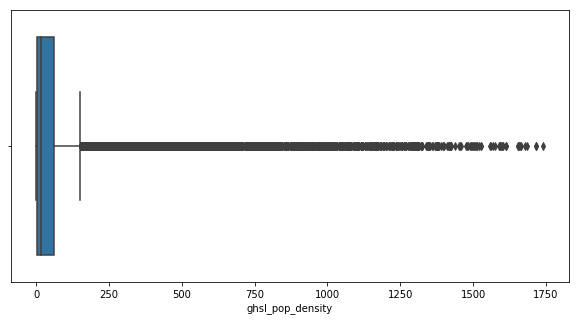

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['ghsl_pop_density'])

In [16]:
print(outliers_prop('ghsl_pop_density'))

0.15698704204344177


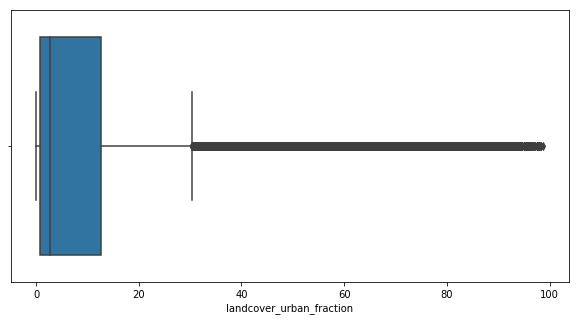

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['landcover_urban_fraction'])

In [18]:
print(outliers_prop('landcover_urban_fraction'))

0.16360585438612846


**We have outliers we should remove**

In [19]:
Q1 = train.iloc[:,4:].quantile(0.25)
Q3 = train.iloc[:,4:].quantile(0.75)
IQR = Q3 - Q1
train = train[~((train.iloc[:,4:] < (Q1 - 1.5 * IQR)) | (train.iloc[:,4:] > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\Omar\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


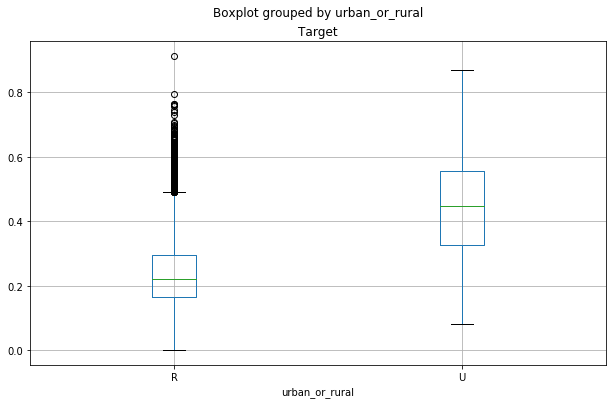

In [20]:
# Looking at the wealth distribution for urban vs rural
train.boxplot(by='urban_or_rural', column='Target', figsize=(10, 6))

Again, not unexpected. Rural areas tend to be less wealthy than urban areas.


In [21]:
train.isna().sum() 

ID                                         0
country                                    0
year                                       0
urban_or_rural                             0
ghsl_water_surface                         0
ghsl_built_pre_1975                        0
ghsl_built_1975_to_1990                    0
ghsl_built_1990_to_2000                    0
ghsl_built_2000_to_2014                    0
ghsl_not_built_up                          0
ghsl_pop_density                           0
landcover_crops_fraction                   0
landcover_urban_fraction                   0
landcover_water_permanent_10km_fraction    0
landcover_water_seasonal_10km_fraction     0
nighttime_lights                           0
dist_to_capital                            0
dist_to_shoreline                          0
Target                                     0
dtype: int64

no missing data!

In [50]:
new_cols = list(relevant_features.index)
test = test[['year','country'] + new_cols[:-1]]
new_cols = ['year','country'] + new_cols
new_cols

['year',
 'country',
 'ghsl_built_1975_to_1990',
 'ghsl_not_built_up',
 'ghsl_pop_density',
 'landcover_urban_fraction',
 'nighttime_lights',
 'Target']

In [51]:
train = train[new_cols]

In [52]:
train.head()

,year,country,ghsl_built_1975_to_1990,ghsl_not_built_up,ghsl_pop_density,landcover_urban_fraction,nighttime_lights,Target
0,2016,Ethiopia,0.000000,0.999408,12.146134,0.879484,0.0,0.132783
1,2005,Ethiopia,0.000110,0.999872,113.806716,0.601427,0.0,0.004898
2,2009,Mozambique,0.000000,1.000000,0.000000,0.131900,0.0,0.097320
6,2004,Cameroon,0.000149,0.999458,0.342950,0.251395,0.0,0.133302
7,2014,Ghana,0.001042,0.997094,14.340860,4.180947,0.0,0.545138


In [53]:
test.head()

,year,country,ghsl_built_1975_to_1990,ghsl_not_built_up,ghsl_pop_density,landcover_urban_fraction,nighttime_lights
0,2007,Democratic Republic of Congo,0.000000,0.999347,0.660758,0.132264,0.000000
1,2007,Democratic Republic of Congo,0.000238,0.991437,6.441547,0.452400,0.000000
2,2011,Uganda,0.132795,0.196373,587.516458,87.387991,60.070041
3,2010,Burkina Faso,0.000036,0.996997,35.141762,4.166437,1.333999
4,2007,Zambia,0.000623,0.995663,3.442449,3.437129,0.502203


In [24]:
x_train, x_val, y_train, y_val = train_test_split(train.iloc[:,1:-1],train['Target'],test_size=0.2,random_state = 42, shuffle = True )

In [25]:
x_train.head()

,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
10493,Cameroon,2011,U,0.0,1.10e-04,3.53e-03,1.62e-03,5.95e-03,0.99,2.13,18.30,1.38,0.00e+00,0.00e+00,2.30,543.09,621.13
6408,Kenya,2015,U,0.0,0.00e+00,2.07e-04,4.13e-04,4.49e-04,1.00,61.02,26.57,6.17,7.75e-03,2.89e-03,0.00,220.38,629.42
5446,Kenya,2014,R,0.0,0.00e+00,1.42e-03,2.30e-03,1.20e-03,1.00,57.74,39.67,6.50,6.65e-03,8.68e-03,0.55,260.90,645.64
3887,Cameroon,2004,U,0.0,2.46e-03,0.00e+00,3.36e-03,0.00e+00,0.99,6.94,1.78,5.83,0.00e+00,0.00e+00,0.93,164.36,159.39
17462,Malawi,2010,R,0.0,2.63e-04,1.76e-04,1.48e-03,1.88e-03,1.00,18.41,27.55,5.58,8.39e-04,1.12e-03,0.00,221.33,370.07


**Let's Normalize years feature values with a small interval of two years**

In [26]:
x_train['year'] = [int((float(a) // 2) - 997) for a in x_train['year']]  

In [27]:
x_val['year'] = [int((float(a) // 2) - 997) for a in x_val['year']]  

In [28]:
test['year'] = [int((float(a) // 2) - 997) for a in test['year']]  

In [26]:
my_cols = list(x_train.columns)
print('Input columns:', my_cols)

Input columns: ['country', 'year', 'urban_or_rural', 'ghsl_water_surface', 'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990', 'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014', 'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction', 'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction', 'landcover_water_seasonal_10km_fraction', 'nighttime_lights', 'dist_to_capital', 'dist_to_shoreline']


In [29]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()

le.fit(pd.concat([x_train['country'],x_val['country'],test['country']],axis=0))
le2.fit(pd.concat([x_train['urban_or_rural'],x_val['urban_or_rural'],test['urban_or_rural']],axis=0))

x_train['country'] = le.transform(x_train['country'])
x_train['urban_or_rural'] = le2.transform(x_train['urban_or_rural'])
x_val['country'] = le.transform(x_val['country'])
x_val['urban_or_rural'] = le2.transform(x_val['urban_or_rural'])
test['country'] = le.transform(test['country'])
test['urban_or_rural'] = le2.transform(test['urban_or_rural'])

In [63]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(x_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x_train,y_train))
coef = pd.Series(reg.coef_, index = x_train.columns)

Best alpha using built-in LassoCV: 0.009038
Best score using built-in LassoCV: 0.422581


In [64]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 8 variables


In [65]:
coef.index

Index(['country', 'year', 'urban_or_rural', 'ghsl_water_surface',
       'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990',
       'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014',
       'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction',
       'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction',
       'landcover_water_seasonal_10km_fraction', 'nighttime_lights',
       'dist_to_capital', 'dist_to_shoreline'],
      dtype='object')

Text(0.5,1,'Feature importance using Lasso Model')

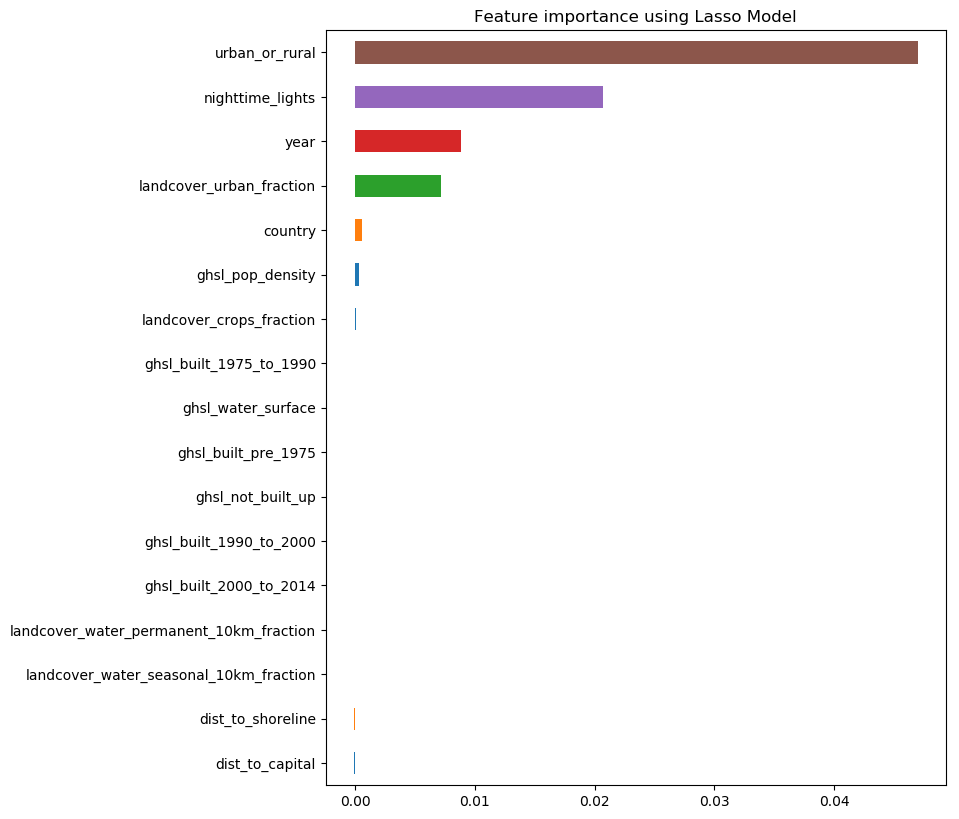

In [66]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [67]:
cols = [x for x in coef.index if coef[x]!=0]
cols

['country',
 'year',
 'urban_or_rural',
 'ghsl_pop_density',
 'landcover_crops_fraction',
 'landcover_urban_fraction',
 'nighttime_lights',
 'dist_to_capital',
 'dist_to_shoreline']

In [68]:
x_train = x_train[cols]
x_val = x_val[cols]
test = test[cols]

In [28]:
test.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,6,6,0,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,6,6,1,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,22,8,1,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334
3,ID_AAmMOEEC,2,8,1,0.000000,0.000089,0.000036,0.001519,0.001358,0.996997,35.141762,33.878927,4.166437,0.000000,0.130727,1.333999,109.493969,775.139189
4,ID_ABguzDxp,23,6,0,0.000000,0.000138,0.000623,0.000615,0.002961,0.995663,3.442449,33.491994,3.437129,0.133563,0.128997,0.502203,133.643319,835.591501


**Scaling the data**

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
test = sc.transform(test.iloc[:,1:])

In [32]:
x_val

array([[-0.29631686, -0.39600039, -0.43378725, ..., -0.435694  ,
        -0.98297428, -0.82558065],
       [-0.7242387 ,  0.43630534, -0.43378725, ..., -0.435694  ,
        -0.31781526, -0.8898233 ],
       [-0.08235594,  0.02015247, -0.43378725, ..., -0.435694  ,
        -0.55481723, -0.30876285],
       ...,
       [-0.51027778,  0.8524582 ,  2.30527752, ..., -0.435694  ,
        -0.37041941,  0.53747603],
       [-1.15216054, -1.22830612, -0.43378725, ..., -0.435694  ,
        -0.31734385, -0.49149535],
       [-2.00800422, -1.22830612, -0.43378725, ...,  0.19272163,
         0.04391484, -0.83053494]])

Now, Data is ready to feed our model.

In [281]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [282]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [283]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 800}

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [35]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ScaledLR: -0.010813 (0.000538)
ScaledLASSO: -0.020406 (0.000682)
ScaledEN: -0.020406 (0.000682)
ScaledKNN: -0.008588 (0.000479)
ScaledCART: -0.013308 (0.001198)
ScaledGBM: -0.007214 (0.000481)


In [46]:
from sklearn.model_selection import GridSearchCV

full_x_train = np.concatenate((x_train, x_val), axis=0)
full_y_train = pd.concat([y_train,y_val])
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(full_x_train, full_y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.007819 (0.000313) with: {'n_estimators': 50}
-0.007141 (0.000274) with: {'n_estimators': 100}
-0.006833 (0.000230) with: {'n_estimators': 200}
-0.006751 (0.000214) with: {'n_estimators': 300}
-0.006720 (0.000221) with: {'n_estimators': 400}
Best: -0.006720 using {'n_estimators': 400}


In [55]:
from sklearn.metrics import mean_squared_error

model = KNeighborsRegressor()
model.fit(x_train, y_train)


predictions = model.predict(x_val)
print (mean_squared_error(y_val, predictions))

0.008374369636665872


In [56]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, model.predict(x_val))

0.065368523130093

In [57]:
print("Training set accuracy = " + str(model.score(x_train, y_train)))
print("Test set accuracy = " + str(model.score(x_val, y_val)))

Training set accuracy = 0.7244419152598508
Test set accuracy = 0.5713699371315596


In [51]:
model = GradientBoostingRegressor(random_state=21, n_estimators=400)
model.fit(full_x_train, full_y_train)
print("Training set accuracy = " + str(model.score(x_train, y_train)))

Training set accuracy = 0.7417181647934962


In [52]:
ss['Target'] = model.predict(test) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.18
1,ID_AAeBMsji,0.15
2,ID_AAjFMjzy,0.18
3,ID_AAmMOEEC,0.27
4,ID_ABguzDxp,0.38


In [53]:
ss.to_csv('first_submission.csv', index=False)

In [75]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(bootstrap = False, max_depth = 30, max_features = 'sqrt', min_samples_leaf = 2,min_samples_split = 10, n_estimators = 800) # Create the model
model.fit(x_train, y_train) # Train it (this syntax looks the same for all sklearn models)
model.score(x_val, y_val)

0.6596629980405023

In [264]:
np.max([estimator.tree_.max_depth for estimator in model.estimators_])

46

In [76]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, model.predict(x_val))

0.058547751424305884

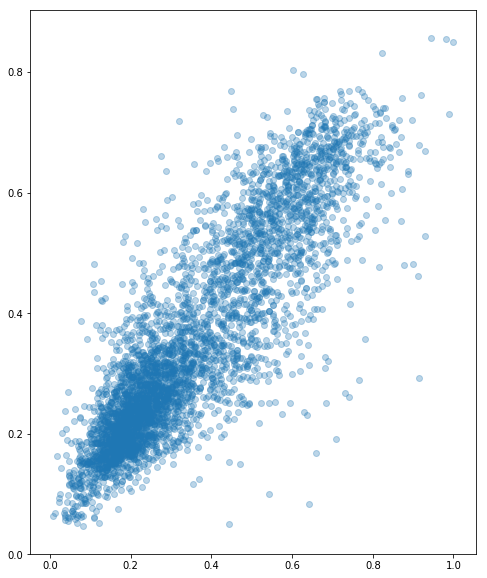

In [244]:
plt.scatter(y_val, model.predict(x_val), alpha=0.3)

In [77]:
print("Training set accuracy = " + str(model.score(x_train, y_train)))
print("Test set accuracy = " + str(model.score(x_val, y_val)))

Training set accuracy = 0.9291290470718325
Test set accuracy = 0.6596629980405023


In [27]:
from sklearn.metrics import mean_squared_error

# The `squared=False` bit tells this function to return the ROOT mean squared error
mean_squared_error(y_val, model.predict(x_val), squared=False)

0.09103373016624709

In [35]:
ss['Target'] = model.predict(test) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.080721
1,ID_AAeBMsji,0.202167
2,ID_AAjFMjzy,0.489627
3,ID_AAmMOEEC,0.408805
4,ID_ABguzDxp,0.242210


In [36]:
ss.to_csv('first_submission.csv', index=False)

In [78]:
from sklearn import datasets, ensemble
reg = ensemble.GradientBoostingRegressor()
reg.fit(x_train, y_train)
mean_absolute_error(y_val, reg.predict(x_val))

0.06141460190182593

In [79]:
print("Training set accuracy = " + str(reg.score(x_train, y_train)))
print("Test set accuracy = " + str(reg.score(x_val, y_val)))

Training set accuracy = 0.6713191526712277
Test set accuracy = 0.6390466739444274


In [81]:
ss['Target'] = reg.predict(test) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.261891
1,ID_AAeBMsji,0.403810
2,ID_AAjFMjzy,0.729041
3,ID_AAmMOEEC,0.670066
4,ID_ABguzDxp,0.492047


In [82]:
ss.to_csv('first_submission.csv', index=False)

In [83]:
reg2 = ensemble.GradientBoostingRegressor(n_estimators=150)
reg2.fit(x_train, y_train)
mean_absolute_error(y_val, reg2.predict(x_val))

0.060169670672570216

In [84]:
print("Training set accuracy = " + str(reg2.score(x_train, y_train)))
print("Test set accuracy = " + str(reg2.score(x_val, y_val)))

Training set accuracy = 0.6924848464383473
Test set accuracy = 0.6507808339729098


In [74]:
ss['Target'] = reg.predict(test[my_cols]) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.140178
1,ID_AAeBMsji,0.181296
2,ID_AAjFMjzy,0.586713
3,ID_AAmMOEEC,0.406987
4,ID_ABguzDxp,0.250190


In [75]:
ss.to_csv('fourth_submission.csv', index=False)

In [63]:
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes = (300, 200, 200, 300), activation = 'relu', solver = 'adam', max_iter = 500, learning_rate = 'adaptive', alpha=0.01)
regressor.fit(x_train, y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(300, 200, 200, 300),
             learning_rate='adaptive', max_iter=500)

In [64]:
mean_squared_error(y_val, regressor.predict(x_val))

0.008881605772246984

In [65]:
print("Training set accuracy = " + str(regressor.score(x_train, y_train)))
print("Test set accuracy = " + str(regressor.score(x_val, y_val)))

Training set accuracy = 0.8095410826571864
Test set accuracy = 0.7612469059663887


In [66]:
ss['Target'] = regressor.predict(test[my_cols]) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.149561
1,ID_AAeBMsji,0.268977
2,ID_AAjFMjzy,0.604845
3,ID_AAmMOEEC,0.328188
4,ID_ABguzDxp,0.162401


In [67]:
ss.to_csv('third_submission.csv', index=False)

In [94]:
model = Sequential()
model.add(Dense(17, activation='relu', input_shape= (17,)))
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.1)))
#model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.summary()
          
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                1152      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 1,523
Trainable params: 1,523
Non-trainable params: 0
_________________________________________________________________
Train on 17163 samples, validate on 4291 samples
Epoch 1/30
17163/17163 [==============================] - 5s 278us/step - loss: 0.1279 - mae: 0.0998 - val_loss: 0.0149 - val_mae: 0.0892
Epoch 2/30
17163/17163 [==============================] - 4s 251us/step - loss: 0.0148 - mae: 0.0915 - val_loss: 0.0194 - val_mae: 0.1068
Epoch 3/30
17163/17163 [==============================] -

In [92]:
ss['Target'] = regressor.predict(test[my_cols]) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.149561
1,ID_AAeBMsji,0.268977
2,ID_AAjFMjzy,0.604845
3,ID_AAmMOEEC,0.328188
4,ID_ABguzDxp,0.162401


In [93]:
ss.to_csv('fifth_submission.csv', index=False)

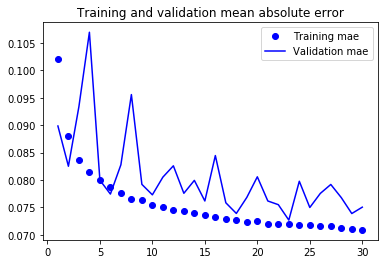

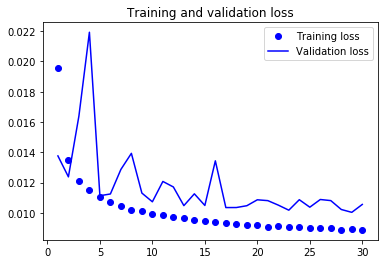

In [91]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Modelling

We've had a look at our data and it looks good! Let's see if we can create a model to predict the Target given some of our inputs. To start with we will use only the numeric columns, so that we can fit a model right away. 

In [11]:
in_cols = list(train.columns[4:-1])
print('Input columns:', in_cols)

Input columns: ['ghsl_water_surface', 'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990', 'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014', 'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction', 'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction', 'landcover_water_seasonal_10km_fraction', 'nighttime_lights', 'dist_to_capital', 'dist_to_shoreline']


To evaluate our model, we need to keep some data separate. We will split out data into X (inputs) and y (output) and then further split into train and test sets with the following code:

In [12]:
from sklearn.model_selection import train_test_split

X, y = train[in_cols], train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58) # Random state keeps the split consistent
print(X_train.shape, X_test.shape)

(17163, 14) (4291, 14)


We now have a nice test set of ~4200 rows. We will train our model and then use this test set to calculate our score.

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() # Create the model
model.fit(X_train, y_train) # Train it (this syntax looks the same for all sklearn models)
model.score(X_test, y_test) # Show a score

0.701354568937301

What is the score above? The default for regression models is the R^2 score, a measure of how well the mode does at predicting the target. 0.69 is pretty good - let's plot the predictions vs the actual values and see how close it looks to a straight line:

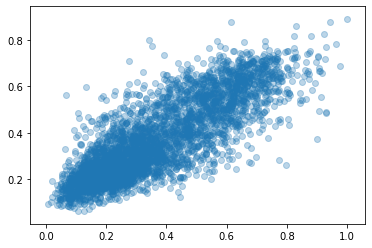

In [14]:
from matplotlib import pyplot as plt
plt.scatter(y_test, model.predict(X_test), alpha=0.3)

This looks great - most predictions are nice and close to the true value! But we still don't have a way to link this to the leaderboard score on Zindi. Let's remedy that by calculating the Root Mean Squared Error, the same metric Zindi uses. 

In [15]:
from sklearn.metrics import mean_squared_error

# The `squared=False` bit tells this function to return the ROOT mean squared error
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.10586008172823101

Great stuff. Let's make a submission and then move on to looking for ways to improve.

In [16]:
# Copying our predictions into the submission dataframe - make sure the rows are in the same order!
ss['Target'] = model.predict(test[in_cols]) 
ss.head()

,ID,Target
0,ID_sSinQhqP,0.631595
1,ID_jvZoqYpZ,0.600302
2,ID_tLfuexnp,0.175044
3,ID_ubXQyliz,0.277712
4,ID_HQVlNyEW,0.448756


We now have our predictions in the right format to submit. The following line saves this to a file that you can then upload to get a score:

In [17]:
ss.to_csv('first_submission.csv', index=False)

# Getting Better

You might have noticed that your score on Zindi wasn't as good as the one you got above. This is because the test set comes from different countries to the train set. When we did a random split, we ended up with our local train and test both coming from the same countries - and it's easier for a model to extrapolate within countries than it is for it to make predictions for a new location. 

So our first step might be to make a scoring function that splits the data according to country, and measures the model performance on unseen countries. Try it and share your testing methods in the discussions. And look at the following questions:
- Does your score drop when you score your model on countries it wasn't trained with?
- Does the new score more accurately match the leaderboard score?
- Are any countries particularly 'hard' to make predictions in?

In [18]:
# You code for a enw model evaluation method here

Knowing how well our model is doing is useful, but however you measure that we also need ways to improve this performance! There are a few ways to do this:

- Feed the model better data. How? Feature engineering! If we can add meaningful features the model will have more data to work with.
- Tune your models. We used the default parameters - perhaps we can tweak some hyperparameters to make our models better
- Try fancier models. Perhaps XGBoost or a neural network is better than Random Forest at this task

Let's do a little of each. First up, let's create a numeric feature that encodes the 'urban_or_rural' column as something the model can use:

In [19]:
# Turning a categorical column into a numeric feature
train['is_urban'] = (train['urban_or_rural'] == 'U').astype(int)
test['is_urban'] = (test['urban_or_rural'] == 'U').astype(int)
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target,is_urban
0,ID_FozRqdOb,Kenya,2014,R,0.000000,0.000168,0.001421,0.002692,0.002674,0.993045,50.425021,24.253201,1.445659,0.005773,0.012893,5.049761,422.115084,9.722168,0.287117,0
1,ID_FVZwryih,Mali,2012,U,0.044830,0.099422,0.312117,0.017019,0.179486,0.347125,538.662650,5.607670,67.043337,1.996433,3.865877,48.076082,9.175895,692.426122,0.672988,1
2,ID_xcldHqPg,Sierra Leone,2013,R,0.000000,0.009695,0.002337,0.010204,0.022974,0.954791,18.041226,4.646198,5.546402,0.012301,0.439747,0.000000,144.744273,103.273286,0.321001,0
3,ID_LehEWHBQ,Ghana,2014,U,0.000000,0.004528,0.009562,0.004075,0.013226,0.968610,77.543652,43.613530,12.698057,2.336585,2.693757,6.832911,597.690289,593.571599,0.580136,1
4,ID_NYBnpVqJ,Guinea,1999,U,0.301125,0.482007,0.084429,0.029285,0.021303,0.081850,530.726927,0.727751,86.264768,2.658005,2.310007,30.920989,10.503972,12.370302,0.467638,1



Note that whenever we add features to train, *we also need to add them to test* otherwise we won't be able to make our predictions.

With this extra feature, we can fit a new model:

In [20]:
in_cols.append('is_urban') # Adding the new features to our list of input columns

# Replace this with your chosen method for evaluating a model:
X, y = train[in_cols], train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)
model = RandomForestRegressor()
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.10209984050879255

Did your score improve?

Next, let's tune our model by adjusting the maximum depth. This is one of many hyperparameters that can be tweaked on a Random Forest model. Here I just try a few randomly chosen values, but you could also use a grid search to try values more methodically.

In [21]:
for max_depth in [3, 5, 8, 10, 14, 18]:
    model = RandomForestRegressor()
    # Again, you van use a better method to evaluate the model here...
    model.fit(X_train, y_train)
    print(max_depth, mean_squared_error(y_test, model.predict(X_test), squared=False))

3 0.10170164526833571
5 0.1021497768770867
8 0.10160947401767634
10 0.10203150335396224
14 0.1017614591328629
18 0.10178234125429858


In this case, it looks like we can improve our performance by specifying a max_depth to limit model complexity.

Finally, let's try a different model out of curiosity:

In [22]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
# Exercise: fit and score the model. Does it beat your other scores? Can you use it to make a submission?

Remember, you can ask questions and share ideas in the discussions. 

### GOOD LUCK!